
## 🧠 LangChain — Foco em Componentes
LangChain é um framework de orquestração para construir agentes e pipelines com LLMs. Ele oferece uma série de abstrações reutilizáveis, como:

LLMs, Prompts, Chains, Tools, Agents, Memory, Retrievers

Ele funciona de forma sequencial (ex: LLMChain) ou com agentes que escolhem o próximo passo.

✅ Ideal para fluxos lineares ou com lógica baseada em linguagem.

## 🔄 LangGraph — Foco em Fluxos de Controle (Graph-Based)
LangGraph é uma biblioteca construída sobre o LangChain para criar fluxos de execução baseados em grafos — ou seja, você modela sua aplicação como nós (nodes) e arestas (edges), que representam a lógica de decisão.

✅ Ideal para construir máquinas de estado, agentes multi-etapas, workflows complexos, retries, loops, branching, etc.

Conceitos principais:
Node = uma função (Runnable) que processa um estado, nós

Edge = transição condicional entre nós, arestas(realiza conexões entre os nós)

Graph = define como os nós se conectam

State = objeto que carrega informações do processo em andamento

In [ ]:
%run ../helpers/00-llm.ipynb

In [ ]:
from helpers.llm import initialize_llm, logger, pretty_print
 
llm, _, _ = initialize_llm()

In [ ]:
from langgraph.graph import StateGraph, END
from IPython.display import Image, display
from langchain_core.runnables import RunnableLambda
from typing import TypedDict
from langchain.prompts import ChatPromptTemplate
from duckduckgo_search import DDGS

# Estado e Funções de CallBack

In [ ]:
class State(TypedDict):
    message: str

def start_node(state):
    print("Início do processo ->")
    return {"message": "Vamos começar!"}      

def process_node(state):
    print("-> Processando:", state["message"])  
    return {"message": state["message"] + " Agora estamos processando."} 

def end_node(state):
    print("-> Finalizando:", state["message"])
    return state

# Cria Grafo

In [ ]:
graph = StateGraph(State)  

graph.add_node("start", RunnableLambda(start_node))  
graph.add_node("process", RunnableLambda(process_node))
graph.add_node("end", RunnableLambda(end_node))



# Transições de Estado

In [ ]:
graph.set_entry_point("start")
graph.add_edge("start", "process")
graph.add_edge("process", "end")
graph.set_finish_point("end")

# Execução

In [ ]:
executable = graph.compile() 

# Executando
final_state = executable.invoke({})
print("\nEstado final:", final_state)

# Estado

In [ ]:
class State(TypedDict):
    pergunta: str  
    conteudo: str 
    resposta: str 

# Funções de CallBack

In [ ]:
def recebe_pergunta(state: State) -> State:
    print(f"Usuário perguntou: {state['pergunta']}")
    return {"pergunta": state["pergunta"]}

def precisa_pesquisar(state: State) -> State:
    pergunta = state["pergunta"].lower()
    precisa = any(p in pergunta for p in ["dados", "estatísticas", "números", "pesquisa"])
    print("Precisa pesquisar?", precisa)
    # Retorna um dicionário, com chave especial para decisão
    return {"next_step": "pesquisar" if precisa else "consultar_llm"}

def pesquisar(state: State) -> State:
    pergunta = state["pergunta"]
    print(f"Pesquisando no DuckDuckGo: {pergunta}")

    with DDGS() as ddgs:
        resultados = ddgs.text(pergunta, max_results=1)

    if resultados:
        contexto = "\n".join([r["body"] for r in resultados if "body" in r])
    else:
        contexto = "Nenhum resultado encontrado."

    return {"conteudo": contexto}    

def consultar_llm(state: State) -> State:
    prompt = ChatPromptTemplate.from_template("Responda à seguinte pergunta: {pergunta}")
    chain = prompt | llm
    resposta = chain.invoke({"pergunta": state["pergunta"]})
    print("Resposta direta do LLM.")
    return {"resposta": resposta.content}

def sintetizar(state: State) -> State:
    contexto = state.get("conteudo", "")
    pergunta = state["pergunta"]
    prompt = ChatPromptTemplate.from_template("""
    Use o seguinte contexto para responder a pergunta:
    Contexto: {contexto}
    Pergunta: {pergunta}
    Resposta:""")
    chain = prompt | llm
    resposta = chain.invoke({"contexto": contexto, "pergunta": pergunta})
    print("Resposta sintetizada com contexto.")
    return {"resposta": resposta.content}

def responder(state: State) -> State:
    print("\n Resposta Final:")
    print(state["resposta"])
    return state

# Cria Grafo

In [ ]:
graph = StateGraph(State)

graph.add_node("recebe_pergunta", RunnableLambda(recebe_pergunta))
graph.add_node("decisao", RunnableLambda(precisa_pesquisar))
graph.add_node("pesquisar", RunnableLambda(pesquisar))
graph.add_node("consultar_llm", RunnableLambda(consultar_llm))
graph.add_node("sintetizar", RunnableLambda(sintetizar))
graph.add_node("responder", RunnableLambda(responder))

# Transições de Estado e Condições

In [ ]:
graph.set_entry_point("recebe_pergunta")

graph.add_edge("recebe_pergunta", "decisao")
graph.add_conditional_edges(
    "decisao",
    lambda state: state["next_step"],  
    {
        "pesquisar": "pesquisar",
        "consultar_llm": "consultar_llm"
    }
)
graph.add_edge("pesquisar", "sintetizar")
graph.add_edge("consultar_llm", "responder")
graph.add_edge("sintetizar", "responder")
graph.set_finish_point("responder")

# Execução

In [17]:
executable = graph.compile()

print("\n TESTE 1:")
executable.invoke({"pergunta": "Qual é a capital da Alemanha?"})




 TESTE 1:
Usuário perguntou: Qual é a capital da Alemanha?
Precisa pesquisar? False


INFO:httpx:HTTP Request: POST https://trainning-grassato-01.openai.azure.com/openai/deployments/gpt-4.1/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


Resposta direta do LLM.

 Resposta Final:
A capital da Alemanha é Berlim.


{'pergunta': 'Qual é a capital da Alemanha?',
 'resposta': 'A capital da Alemanha é Berlim.'}

In [18]:
print("\n  TESTE 2:")
executable.invoke({"pergunta": "Me mostre dados sobre economia brasileira em 2025."})


  TESTE 2:
Usuário perguntou: Me mostre dados sobre economia brasileira em 2025.
Precisa pesquisar? True
Pesquisando no DuckDuckGo: Me mostre dados sobre economia brasileira em 2025.


/tmp/ipykernel_25803/1028576957.py:16: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
INFO:primp:response: https://www.bing.com/search?q=Me+mostre+dados+sobre+economia+brasileira+em+2025. 200
INFO:httpx:HTTP Request: POST https://trainning-grassato-01.openai.azure.com/openai/deployments/gpt-4.1/chat/completions?api-version=2025-01-01-preview "HTTP/1.1 200 OK"


Resposta sintetizada com contexto.

 Resposta Final:
Em 2025, a economia brasileira apresenta os seguintes dados e tendências:

- **Crescimento do PIB:** Projeções indicam um crescimento moderado, entre 2% e 2,5%, impulsionado principalmente pelo agronegócio, energia renovável e tecnologia.
- **Inflação:** A inflação permanece sob controle, com estimativas em torno de 4% ao ano, dentro da meta estabelecida pelo Banco Central.
- **Taxa de desemprego:** A taxa de desemprego segue em queda gradual, situando-se entre 7% e 8%, refletindo a recuperação de setores produtivos.
- **Investimentos estrangeiros:** O Brasil continua atraindo investimentos, especialmente em energia limpa e inovação tecnológica, com fluxo de capital estrangeiro em alta.
- **Setores em destaque:** O agronegócio mantém forte desempenho nas exportações, enquanto energia renovável (solar e eólica) e tecnologia apresentam crescimento acelerado.
- **Desafios:** Apesar dos avanços, o país ainda enfrenta desafios como desigu

{'pergunta': 'Me mostre dados sobre economia brasileira em 2025.',
 'conteudo': 'Em 2025, a economia brasileira apresenta um cenário de crescimento moderado, impulsionado por setores-chave como agronegócio, energia renovável e tecnologia, mas ainda enfrenta desafios …',
 'resposta': 'Em 2025, a economia brasileira apresenta os seguintes dados e tendências:\n\n- **Crescimento do PIB:** Projeções indicam um crescimento moderado, entre 2% e 2,5%, impulsionado principalmente pelo agronegócio, energia renovável e tecnologia.\n- **Inflação:** A inflação permanece sob controle, com estimativas em torno de 4% ao ano, dentro da meta estabelecida pelo Banco Central.\n- **Taxa de desemprego:** A taxa de desemprego segue em queda gradual, situando-se entre 7% e 8%, refletindo a recuperação de setores produtivos.\n- **Investimentos estrangeiros:** O Brasil continua atraindo investimentos, especialmente em energia limpa e inovação tecnológica, com fluxo de capital estrangeiro em alta.\n- **Setores e

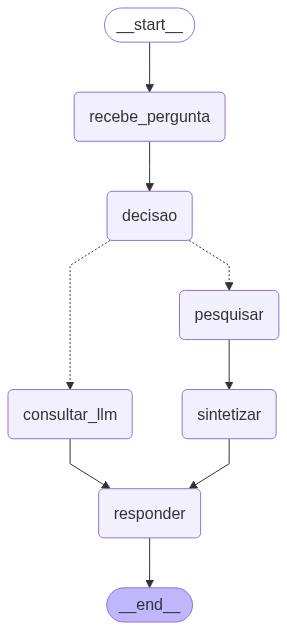

              +-----------+                 
              | __start__ |                 
              +-----------+                 
                    *                       
                    *                       
                    *                       
           +-----------------+              
           | recebe_pergunta |              
           +-----------------+              
                    *                       
                    *                       
                    *                       
               +---------+                  
               | decisao |                  
               +---------+                  
             ..           ...               
           ..                ..             
         ..                    ..           
+-----------+                    ..         
| pesquisar |                     .         
+-----------+                     .         
       *                          .         
       *  

In [19]:
# Exibindo o grafo
display(Image(executable.get_graph().draw_mermaid_png()))

print(executable.get_graph().print_ascii())

## Exemplo 3

In [ ]:
 
class ChatState(TypedDict):
    pergunta: str
    resposta: str

# Função que responde perguntas
def responder(state: ChatState) -> ChatState:
    pergunta = state.get("pergunta", "")
    resposta = llm.invoke(pergunta)
    return {"pergunta": pergunta, "resposta": resposta.content}

# Construindo o grafo
builder = StateGraph(ChatState)
 
builder.add_node("responder", responder)

builder.set_entry_point("responder")
builder.add_edge("responder", END)




In [ ]:
# Compilando o grafo
graph = builder.compile()
 

In [ ]:
# Exibindo o grafo
display(Image(graph.get_graph().draw_mermaid_png()))

print(graph.get_graph().print_ascii())


In [ ]:
pergunta = "Qual a capital do Brasil?"

# Criando o agente
entrada = ChatState({"pergunta": pergunta})
resultado = graph.invoke(entrada)

print(resultado)